<a href="https://colab.research.google.com/github/NickStitely/PyTorch/blob/main/NLP_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the Imports and Tools/Data Set

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
import nltk
#nltk.download('all')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [4]:
# Load the Data Set
file_names = ['https://raw.githubusercontent.com/NickStitely/PyTorch/refs/heads/main/IMDB%20Dataset_1.csv', 'https://raw.githubusercontent.com/NickStitely/PyTorch/refs/heads/main/IMDB%20Dataset_2.csv', 'https://raw.githubusercontent.com/NickStitely/PyTorch/refs/heads/main/IMDB%20Dataset_3.csv']

df1 = pd.read_csv(file_names[0])
df2 = pd.read_csv(file_names[1])
df3 = pd.read_csv(file_names[2])
len(df1) + len(df2) + len(df3)

50000

In [5]:
# Combine the data frames
df = pd.concat([df1, df2, df3])

train data shape: (37500,)
train data shape: (12500,)


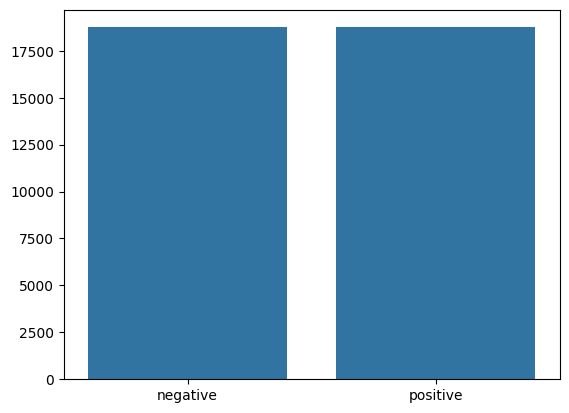

In [6]:
# Explore the Data
x = df["review"].values
y = df["sentiment"].values

# Split the data into train and test sets. Use stratify
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
print (f'train data shape: {x_train.shape}')
print (f'train data shape: {x_test.shape}')

# Plot the results of training data split
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative', 'positive']), y=dd.values)
plt.show()

# Tokenize the Data Set

In [7]:
# Create preprocess_string function
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"\s+", '', s) # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s) # replace digits with no space
    return s

In [8]:
# Create tokenize function
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000] # sorting on the basis of most common words
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)} # creating a dict

    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]

    return final_list_train, encoded_train, final_list_test, encoded_test, onehot_dict
    #return np.array(final_list_train),np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [9]:
# Prepare the data for the model
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [10]:
# Train the model, can only run this once or have to re-run the whole thing
temp_x_train,temp_y_train,temp_x_test,temp_y_test,temp_vocab = tokenize(x_train,y_train,x_test,y_test)

In [11]:
# This seems wrong, why are we artificially playing with the token lengths. Especially when the next steps analyzes the token length??
# They do it anyway below but why is it fine to do so?
#x_train = np.array(padding_(temp_x_train,max(len(lst) for lst in temp_x_train))) # lets reduce to 500
#x_test = np.array(padding_(temp_x_test,max(len(lst) for lst in temp_x_test))) # lets reduce to 500
x_train = np.array(padding_(temp_x_train,500))
x_test = np.array(padding_(temp_x_test,500))
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)
vocab = temp_vocab

In [12]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


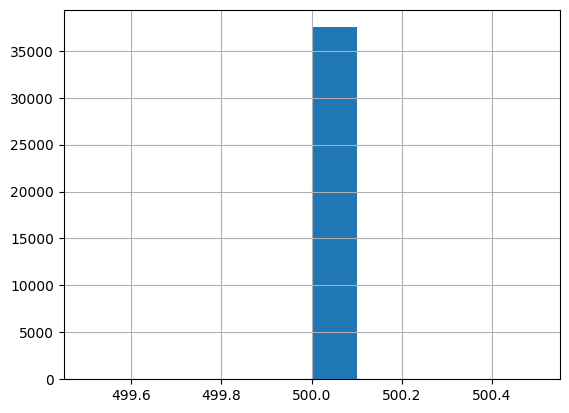

,0
count,37500.0
mean,500.0
std,0.0
min,500.0
25%,500.0
50%,500.0
75%,500.0
max,500.0


In [13]:
# Analyze the token lengths
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [14]:
# Filter reviews more than 500 characters
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

# Setup the Training

In [15]:
# Create a Tensor DataSet to generate final datasets for training
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

In [16]:
# dataloaders
batch_size = 50

# Setup the data loaders - shuffle the data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [17]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 734,  57, 689],
        [  0,   0,   0,  ...,   1, 413, 100],
        [  0,   0,   0,  ..., 320,  17,   2],
        ...,
        [  0,   0,   0,  ..., 304,  11,  95],
        [  0,   0,   0,  ..., 576, 337, 406],
        [  0,   0,   0,  ..., 272, 150,  23]])
Sample output: 
 tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0])


In [18]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [19]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [21]:
clip = 5
epochs = 5
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

KeyboardInterrupt: 

# Evaluate the Results

In [ ]:
# Plot the results and loss
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()

In [ ]:
# Inference and Prediction
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())


index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')